Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Applying baseline correction (mode: logratio)
No baseline correction a

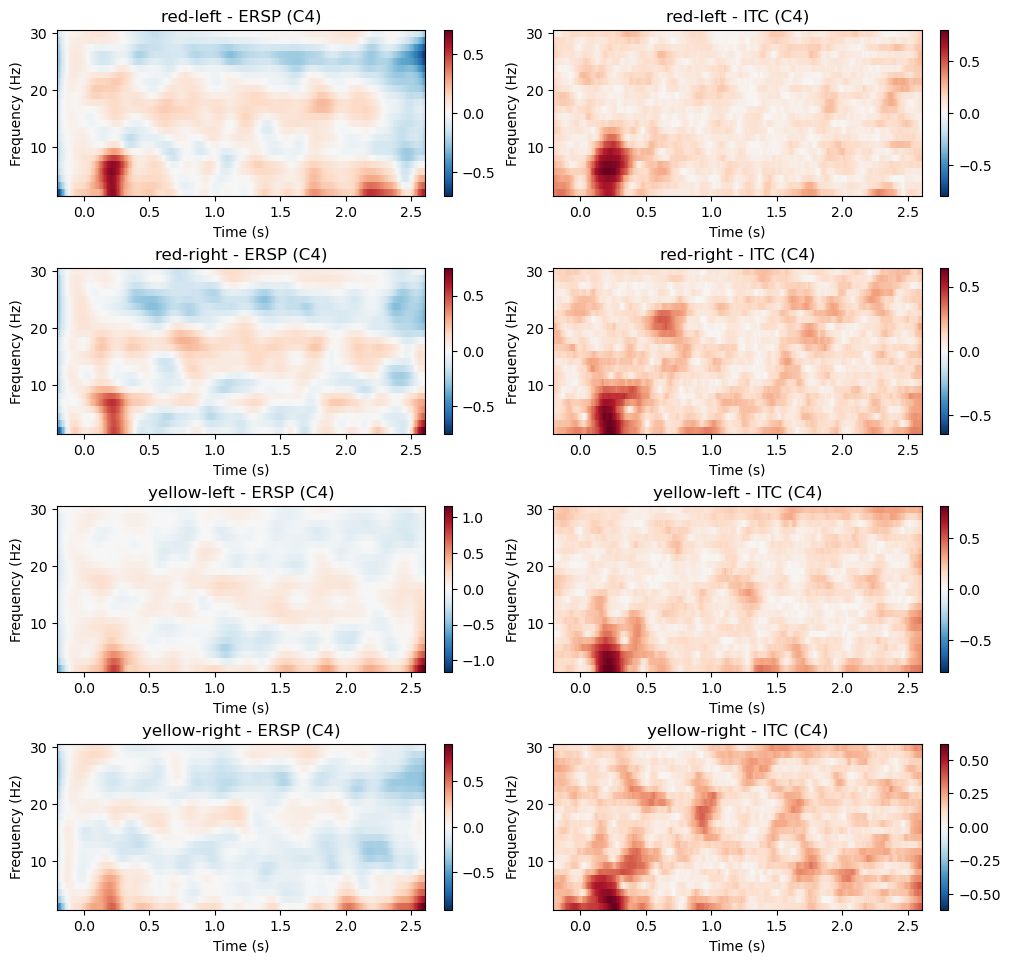

In [2]:
import mat73, numpy as np, mne
from scipy.stats import sem, t

# ---------- 1) Read and format OUT into a list[dict] ----------
def load_out_list(paths):
    all_recs = []
    for p in paths:
        d = mat73.loadmat(p)
        OUT = d['OUT']
        if isinstance(OUT, dict):
            N = len(next(v for v in OUT.values() if hasattr(v, '__len__')))
            recs = []
            for i in range(N):
                recs.append({k: (v[i] if hasattr(v, '__len__') else v) for k, v in OUT.items()})
        else:
            recs = list(OUT)
        all_recs.extend(recs)
    return all_recs

def norm_label(x):
    s = str(x).strip()
    if len(s)>=2 and s[0]==s[-1] and s[0] in ('"', "'"):
        s = s[1:-1]
    return s.lower()

def select_trials(records, color, direct):
    color = norm_label(color); direct = norm_label(direct)
    out = []
    for r in records:
        bc = norm_label(r.get('ball_color','')); md = norm_label(r.get('move_direct',''))
        if bc==color and md==direct:
            out.append(r)
    return out

# ---------- 2) Unify the EEG trial of a certain channel to an equal length (N,1,L) ----------
def pad_or_cut(x, L, pad_val=np.nan):
    x = np.asarray(x, float).squeeze()
    if x.size >= L: return x[:L]
    y = np.full(L, pad_val, float); y[:x.size] = x; return y

def make_epochs_1ch(trials, ch_idx, L_target, fs, tmin_s=-0.2):
    X = []
    for r in trials:
        EEG = np.asarray(r['EEG'], float)
        if EEG.ndim != 2:
            raise ValueError("EEG Not a two-dimensional matrix")
        # Automatically convert to (C,T): If the first dimension does not resemble the number of channels, transpose it
        if EEG.shape[0] not in (26,32,62,64) and EEG.shape[1] in (26,32,62,64):
            EEG = EEG.T
        sig = EEG[ch_idx]
        sig = pad_or_cut(sig, L_target, pad_val=np.nan)
        # Fill NaN with baseline mean (especially for the first 200ms of NaN)
        base_len = int(abs(tmin_s) * fs)  # 100Hz * 0.2s = 20 points
        base = np.nanmean(sig[:base_len]) if base_len > 0 else 0.0
        sig = np.nan_to_num(sig, nan=base)
        X.append(sig)
    X = np.asarray(X, float)   # (N, L)
    X = X[:, None, :]          # (N, 1, L)
    info = mne.create_info(ch_names=['ch_sel'], sfreq=fs, ch_types='eeg')
    times = np.arange(L_target) / fs + tmin_s
    return X, info, times

# ============== compute ERSP & ITC ==============
def compute_ersp_itc(X, info, freqs, n_cycles, base_win):
    epochs = mne.EpochsArray(X, info, tmin=tmin_s)  # tmin correspond to -0.2s
    power, itc = mne.time_frequency.tfr_morlet(
        epochs, freqs=freqs, n_cycles=n_cycles,
        use_fft=True, return_itc=True, average=True, decim=1
    )
    # Baseline correction (crucial for ERSP; ITC itself does not require baseline correction for 0–1)
    power.apply_baseline(baseline=base_win, mode='logratio')
    return power, itc

# ---------- 3) compute ERSP (power) & ITC ----------
def compute_ersp_itc(X, info, freqs=np.linspace(2,30,24), average=True):
    # X: (N,1,L)
    epochs = mne.EpochsArray(X, info, tmin=times[0])  # times[0] = tmin_s
    n_cycles = freqs/2.0
    power, itc = mne.time_frequency.tfr_morlet(
        epochs, freqs=freqs, n_cycles=n_cycles,
        use_fft=True, return_itc=True, average=average
    )
    # Baseline correction：-0.2~0 s
    power.apply_baseline(baseline=(-0.2, 0.0), mode='logratio')
    return power, itc

# ================== actual execution ==================
paths = [r"D:\Datasets\s3\preprocessed data\motion_execution\eeg_leap_L1.mat",
         r"D:\Datasets\s3\preprocessed data\motion_execution\eeg_leap_L2.mat",
         r"D:\Datasets\s3\preprocessed data\motion_execution\eeg_leap_L3.mat",
         r"D:\Datasets\s3\preprocessed data\motion_execution\eeg_leap_L4.mat"]


records = load_out_list(paths)

conds = {
    "red-left":   select_trials(records, "red",    "left"),
    "red-right":   select_trials(records, "red",    "right"),
    "yellow-left": select_trials(records, "yellow", "left"),
    "yellow-right": select_trials(records, "yellow", "right"),
}

# Sampling rate & uniform length
fs = 100
freqs = np.linspace(2, 30, 24)
n_cycles = np.interp(freqs, [2, 30], [7, 3])
L_target = int(np.median([len(np.asarray(r['t_ms']).squeeze()) for r in records]))
tmin_s = -0.2

# Select channel
ch_idx = 13

ersp_itc = {}
for name, trials in conds.items():
    if len(trials)==0:
        print(f"{name}: No trial, skip")
        continue
    X, info, times = make_epochs_1ch(trials, ch_idx, L_target, fs, tmin_s=tmin_s)
    power, itc = compute_ersp_itc(X, info)
    ersp_itc[name] = (power, itc)

# ---------- 4) plot ----------
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(ersp_itc), 2, figsize=(10, 2.4*len(ersp_itc)), constrained_layout=True)
if len(ersp_itc)==1: axes = np.array([axes])  # Unify into two dimensions
for i, (name, (pwr, itc)) in enumerate(ersp_itc.items()):
    pwr.plot(picks=[0], axes=axes[i,0], colorbar=True, show=False)
    axes[i,0].set_title(f"{name} - ERSP (C4)")
    itc.plot(picks=[0], axes=axes[i,1], colorbar=True, show=False)
    axes[i,1].set_title(f"{name} - ITC (C4)")
plt.savefig('./s3_left_C4_ersp_itc.png', dpi=300)
plt.show()

C:\Users\cmp\AppData\Local\Temp\ipykernel_103660\1776974888.py:5: RuntimeWarning: Mean of empty slice
  m = np.nanmean(arr, axis=0)


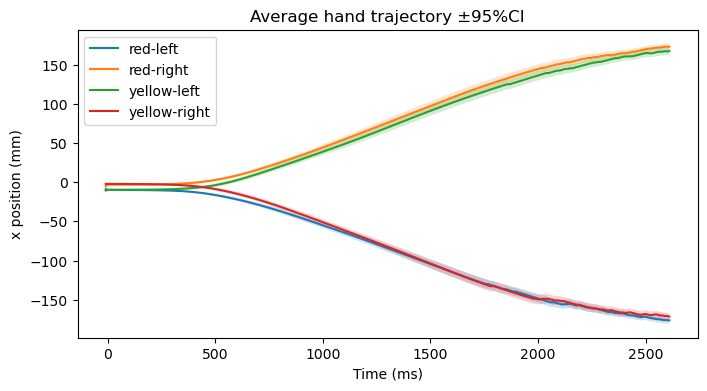

In [3]:
from scipy.stats import sem, t

def mean_ci(data, conf=0.95):
    arr = np.stack(data)
    m = np.nanmean(arr, axis=0)
    se = sem(arr, axis=0, nan_policy='omit')
    h = se * t.ppf((1+conf)/2., arr.shape[0]-1)
    return m, h

traj_dict = {}
for k,v in conds.items():
    xs = [pad_or_cut(np.array(o['x_mm'], float), L_target, np.nan) for o in v]
    m,h = mean_ci(xs)
    traj_dict[k] = (m,h)

# Draw trajectory curve
plt.figure(figsize=(8,4))
t_axis = np.linspace(-200, L_target/fs*1000-200, L_target)  # Align to ms
for cond, (m,h) in traj_dict.items():
    plt.plot(t_axis, m, label=cond)
    plt.fill_between(t_axis, m-h, m+h, alpha=0.2)
plt.xlabel('Time (ms)')
plt.ylabel('x position (mm)')
plt.title('Average hand trajectory ±95%CI')
plt.legend()
plt.savefig('./s3_left_trajectory.png', dpi=300)
plt.show()
